In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pydicom as dicom
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score

import os
import sys
import time
import numpy as np
import pandas as pd
import cv2
import PIL.Image
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import CosineAnnealingLR
from warmup_scheduler import GradualWarmupScheduler  # https://github.com/ildoonet/pytorch-gradual-warmup-lr
import albumentations as A
import geffnet

In [26]:
df = pd.read_csv('data/ISIC_2020_Training_GroundTruth_v2.csv')
df.head()

,image_name,patient_id,lesion_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,IL_7972535,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,IL_4649854,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,IL_9087444,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,IL_4255399,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,IL_6898037,female,55.0,upper extremity,unknown,benign,0


In [27]:
df.shape

(33126, 9)

In [28]:
melanoma = df[df.target == 1]
non_melanoma = df[df.target == 0]

In [29]:
melanoma.shape

(584, 9)

In [30]:
non_melanoma.shape

(32542, 9)

In [31]:
y_mel = melanoma.target
X_mel = melanoma.drop(columns=['target'], axis=1)
y_non_mel = non_melanoma.target
X_non_mel = non_melanoma.drop(columns=['target'], axis=1)

In [32]:
from sklearn.model_selection import train_test_split

X_tr_m, X_tt_m, y_tr_m, y_tt_m = train_test_split(X_mel, y_mel, random_state=42, test_size=0.2)
X_tr_nm, X_tt_nm, y_tr_nm, y_tt_nm = train_test_split(X_non_mel, y_non_mel, random_state=42, test_size=0.2)

In [36]:
mel_train = pd.concat([X_tr_m, y_tr_m], axis=1)
non_mel_train = pd.concat([X_tr_nm, y_tr_nm], axis=1)
mel_test = pd.concat([X_tt_m, y_tt_m], axis=1)
non_mel_test = pd.concat([X_tt_nm, y_tt_nm], axis=1)

In [37]:
train = pd.concat([mel_train, non_mel_train], axis=0)
test = pd.concat([mel_test, non_mel_test], axis=0)

In [39]:
train = train.reset_index(drop=True)
train.head()

,image_name,patient_id,lesion_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_1569119,IP_6120178,IL_3157235,male,65.0,torso,melanoma,malignant,1
1,ISIC_7536704,IP_3994607,IL_1685088,male,75.0,torso,melanoma,malignant,1
2,ISIC_3696488,IP_6051587,IL_8878499,female,90.0,upper extremity,melanoma,malignant,1
3,ISIC_3343475,IP_4576785,IL_9262145,male,80.0,head/neck,melanoma,malignant,1
4,ISIC_7785723,IP_8447624,IL_2711936,female,50.0,lower extremity,melanoma,malignant,1


In [41]:
train.shape

(26500, 9)

In [40]:
test = test.reset_index(drop=True)
test.head()

,image_name,patient_id,lesion_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_6767569,IP_7665112,IL_1769376,male,70.0,head/neck,melanoma,malignant,1
1,ISIC_7312977,IP_8675890,IL_2723500,male,55.0,lower extremity,melanoma,malignant,1
2,ISIC_1785627,IP_0170821,IL_6029631,female,40.0,upper extremity,melanoma,malignant,1
3,ISIC_8066110,IP_3055814,IL_7066374,male,50.0,lower extremity,melanoma,malignant,1
4,ISIC_8838753,IP_6292815,IL_9486623,female,65.0,lower extremity,melanoma,malignant,1


In [42]:
test.shape

(6626, 9)

In [7]:
df = df.rename(columns={'anatom_site_general_challenge': 'site'})

In [8]:
df.head()

,image_name,patient_id,lesion_id,sex,age_approx,site,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,IL_7972535,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,IL_4649854,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,IL_9087444,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,IL_4255399,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,IL_6898037,female,55.0,upper extremity,unknown,benign,0


In [9]:
df.shape

(33126, 9)

<AxesSubplot:xlabel='sex', ylabel='count'>

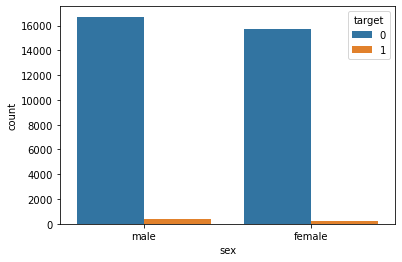

In [10]:
sns.countplot(x='sex', data=df, hue='target')

/Users/examsherpa/opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age_approx', ylabel='Density'>

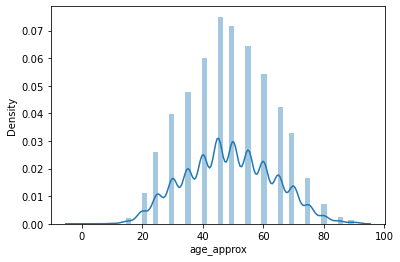

In [11]:
sns.distplot(df['age_approx'])

<AxesSubplot:xlabel='site', ylabel='count'>

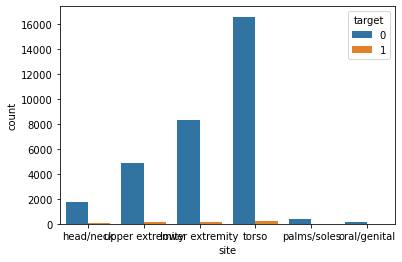

In [12]:
sns.countplot(x='site', data=df, hue='target')

In [14]:
df.diagnosis.value_counts()

unknown                               27124
nevus                                  5193
melanoma                                584
seborrheic keratosis                    135
lentigo NOS                              44
lichenoid keratosis                      37
solar lentigo                             7
cafe-au-lait macule                       1
atypical melanocytic proliferation        1
Name: diagnosis, dtype: int64

In [15]:
df.site.value_counts()

torso              16845
lower extremity     8417
upper extremity     4983
head/neck           1855
palms/soles          375
oral/genital         124
Name: site, dtype: int64

In [16]:
import os, shutil

In [84]:
train.head()

,image_name,patient_id,lesion_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,file
0,ISIC_1569119,IP_6120178,IL_3157235,male,65.0,torso,melanoma,malignant,1,ISIC_1569119.jpg
1,ISIC_7536704,IP_3994607,IL_1685088,male,75.0,torso,melanoma,malignant,1,ISIC_7536704.jpg
2,ISIC_3696488,IP_6051587,IL_8878499,female,90.0,upper extremity,melanoma,malignant,1,ISIC_3696488.jpg
3,ISIC_3343475,IP_4576785,IL_9262145,male,80.0,head/neck,melanoma,malignant,1,ISIC_3343475.jpg
4,ISIC_7785723,IP_8447624,IL_2711936,female,50.0,lower extremity,melanoma,malignant,1,ISIC_7785723.jpg


In [47]:
train['file'] = train.image_name.apply(lambda x: str(x) + ".jpg")
test['file'] = test.image_name.apply(lambda x: str(x) + ".jpg")
train.file

0        ISIC_1569119.jpg
1        ISIC_7536704.jpg
2        ISIC_3696488.jpg
3        ISIC_3343475.jpg
4        ISIC_7785723.jpg
               ...       
26495    ISIC_9166979.jpg
26496    ISIC_1738297.jpg
26497    ISIC_0365032.jpg
26498    ISIC_4919947.jpg
26499    ISIC_7309302.jpg
Name: file, Length: 26500, dtype: object

In [74]:
train_ids = train.file
test_ids = test.file

In [90]:
train.head()
train.to_csv("data/train.csv")
test.to_csv("data/test.csv")

In [59]:
jpeg_dir = 'images/jpeg'
dicom_dir = 'images/dicom'
jpeg_list = [file for file in os.listdir(jpeg_dir) if file.endswith('.jpg')]
dicom_list = [file for file in os.listdir(dicom_dir) if file.endswith('.dcm')]

In [73]:
train_ids = train.file
test_ids = test.file
train_ids

0        ISIC_1569119.jpg
1        ISIC_7536704.jpg
2        ISIC_3696488.jpg
3        ISIC_3343475.jpg
4        ISIC_7785723.jpg
               ...       
26495    ISIC_9166979.jpg
26496    ISIC_1738297.jpg
26497    ISIC_0365032.jpg
26498    ISIC_4919947.jpg
26499    ISIC_7309302.jpg
Name: file, Length: 26500, dtype: object

In [89]:
train.target = train.target.astype(str)

In [78]:
import csv
import os

with open('data/train.csv', newline='') as csvfile:
    linereader = csv.reader(csvfile, delimiter=',')
    for row in linereader:
        name = row[0]
        try:
            os.('images/jpeg/' + name, 'images/jpeg/train/' + name)
            print(name + " moved to new folder.")
        except FileNotFoundError:
            pass 
        except FileExistsError:
            pass

OSError: [Errno 22] Invalid argument: 'images/jpeg/' -> 'images/jpeg/train/'

In [81]:
train_csv = pd.read_csv("data/train.csv")
train_csv.head()

,Unnamed: 0,file
0,0,ISIC_1569119.jpg
1,1,ISIC_7536704.jpg
2,2,ISIC_3696488.jpg
3,3,ISIC_3343475.jpg
4,4,ISIC_7785723.jpg


In [83]:
import csv
import os
import shutil

def main():
    csv_file = "data/train.csv"
    from_folder = "images/jpeg/"
    to_folder = "images/jpeg/train/"

    with open(csv_file, 'r', newline='') as f:
        reader = csv.reader(f)

        for row in reader:
            file_name = row[0]
            from_filename = os.path.join(from_folder, file_name)
            to_filename = os.path.join(to_folder, file_name)

            try:
                shutil.move(from_filename, to_filename)
                print("Moved - '{}' -> '{}'".format(from_filename, to_filename))
            except shutil.Error as e:
                print("Failed - '{}' -> '{}'".format(from_filename, to_filename))

main()

Failed - 'images/jpeg/' -> 'images/jpeg/train/'


FileNotFoundError: [Errno 2] No such file or directory: 'images/jpeg/0'

In [ ]:
test_generator = ImageDataGenerator(), flow_from _directory(
        t
)

In [67]:
import splitfolders
splitfolders.ratio(jpeg_dir, output="output", seed=42, ratio=(.8,0.1,0.1))

Copying files: 497 files [04:28,  1.85 files/s]


In [69]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import regularizers, optimizers
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Converting DICOM into PNG

In [ ]:
import pydicom as dicom
import matplotlib.pyplot as plt
import os
import cv2
import PIL # optional
import pandas as pd
import csv

# make it True if you want in PNG format
PNG = True
# Specify the .dcm folder path
folder_path = "images/test"
# Specify the .jpg/.png folder path
jpg_folder_path = "images/png_test"
images_path = os.listdir(folder_path)
for n, image in enumerate(images_path):
    ds = dicom.dcmread(os.path.join(folder_path, image))
    pixel_array_numpy = ds.pixel_array
    if PNG == False:
        image = image.replace('.dcm', '.jpg')
    else:
        image = image.replace('.dcm', '.png')
    cv2.imwrite(os.path.join(jpg_folder_path, image), pixel_array_numpy)
    if n % 50 == 0:
        print('{} image converted'.format(n))


In [ ]:
folder_path = "images/jpeg"
train_path = "images/jpeg/train"

In [ ]:
# make it True if you want in PNG format
PNG = True
# Specify the .dcm folder path
folder_path = "images/train"
# Specify the .jpg/.png folder path
jpg_folder_path = "images/png_train"
images_path = os.listdir(folder_path)
for n, image in enumerate(images_path):
    ds = dicom.dcmread(os.path.join(folder_path, image))
    pixel_array_numpy = ds.pixel_array
    if PNG == False:
        image = image.replace('.dcm', '.jpg')
    else:
        image = image.replace('.dcm', '.png')
    cv2.imwrite(os.path.join(jpg_folder_path, image), pixel_array_numpy)
    if n % 50 == 0:
        print('{} image converted'.format(n))

In [ ]:
# specify your image path
image_path = 'xray.dcm'
ds = dicom.dcmread(image_path)
plt.imshow( ds.pixel_array)

plt.show()

In [ ]:
import time
import matplotlib.pyplot as plt
import scipy
import numpy as np
from PIL import Image
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

np.random.seed(123)

In [91]:
df = pd.read_csv("data/train.csv")

In [93]:
df.head()

,Unnamed: 0,image_name,patient_id,lesion_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,file
0,0,ISIC_1569119,IP_6120178,IL_3157235,male,65.0,torso,melanoma,malignant,1,ISIC_1569119.jpg
1,1,ISIC_7536704,IP_3994607,IL_1685088,male,75.0,torso,melanoma,malignant,1,ISIC_7536704.jpg
2,2,ISIC_3696488,IP_6051587,IL_8878499,female,90.0,upper extremity,melanoma,malignant,1,ISIC_3696488.jpg
3,3,ISIC_3343475,IP_4576785,IL_9262145,male,80.0,head/neck,melanoma,malignant,1,ISIC_3343475.jpg
4,4,ISIC_7785723,IP_8447624,IL_2711936,female,50.0,lower extremity,melanoma,malignant,1,ISIC_7785723.jpg


In [95]:
df['target'] = df['target'].astype(str)

In [96]:
df.target.dtype

dtype('O')

In [101]:
datagen = ImageDataGenerator(rescale=1./255.,validation_split=0.20)
train_generator=datagen.flow_from_dataframe(
    dataframe=df,
    directory="images/jpeg",
    x_col="file",
    y_col="target",
    subset="training",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="raw",
    target_size=(256,256))

Found 20876 validated image filenames.
/Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.6/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 406 invalid image filename(s) in x_col="file". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [98]:
datagen

In [99]:
next(datagen)

TypeError: 'ImageDataGenerator' object is not an iterator

In [100]:
next(iter(datagen))

TypeError: 'ImageDataGenerator' object is not iterable